## Data Wrangling

### Imports

In [58]:
# Fixes threadpoolctl to skip BLAS probing issues on Windows
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]       = "1"
os.environ["MKL_NUM_THREADS"]       = "1"
import contextlib, threadpoolctl
def no_op_threadpool_limits(limits=None, user_api=None):
    return contextlib.nullcontext()
threadpoolctl.threadpool_limits = no_op_threadpool_limits

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (make_scorer, roc_auc_score, precision_recall_curve, f1_score,
                             classification_report, precision_score, recall_score, average_precision_score)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore') # suppress warnings

### Read In & Inspect Data

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Note: Due to confidentiality limitations, PCA components are provided rather than original features (e.g., merchant category, card type, or location). While the PCA components keep variability intact, using them directly removes the need for proper feature engineering that would typically be done beforehand - this is a limitation of public use data.

## EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

All values are numeric and there are no missing values. We have 28 PCA components, Time, Amount, and Class. The Time feature is the number of seconds that have elapsed between this transaction and the first transaction; with a max of 179792, this dataset encompasses 48 hours of transactions. The Amount feature is self-explanatory. And finally, Class is the binary target feature to denote fraud.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [11]:
# Check class imbalance
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

As expected, the positive class (fraud) is much less prevalent.

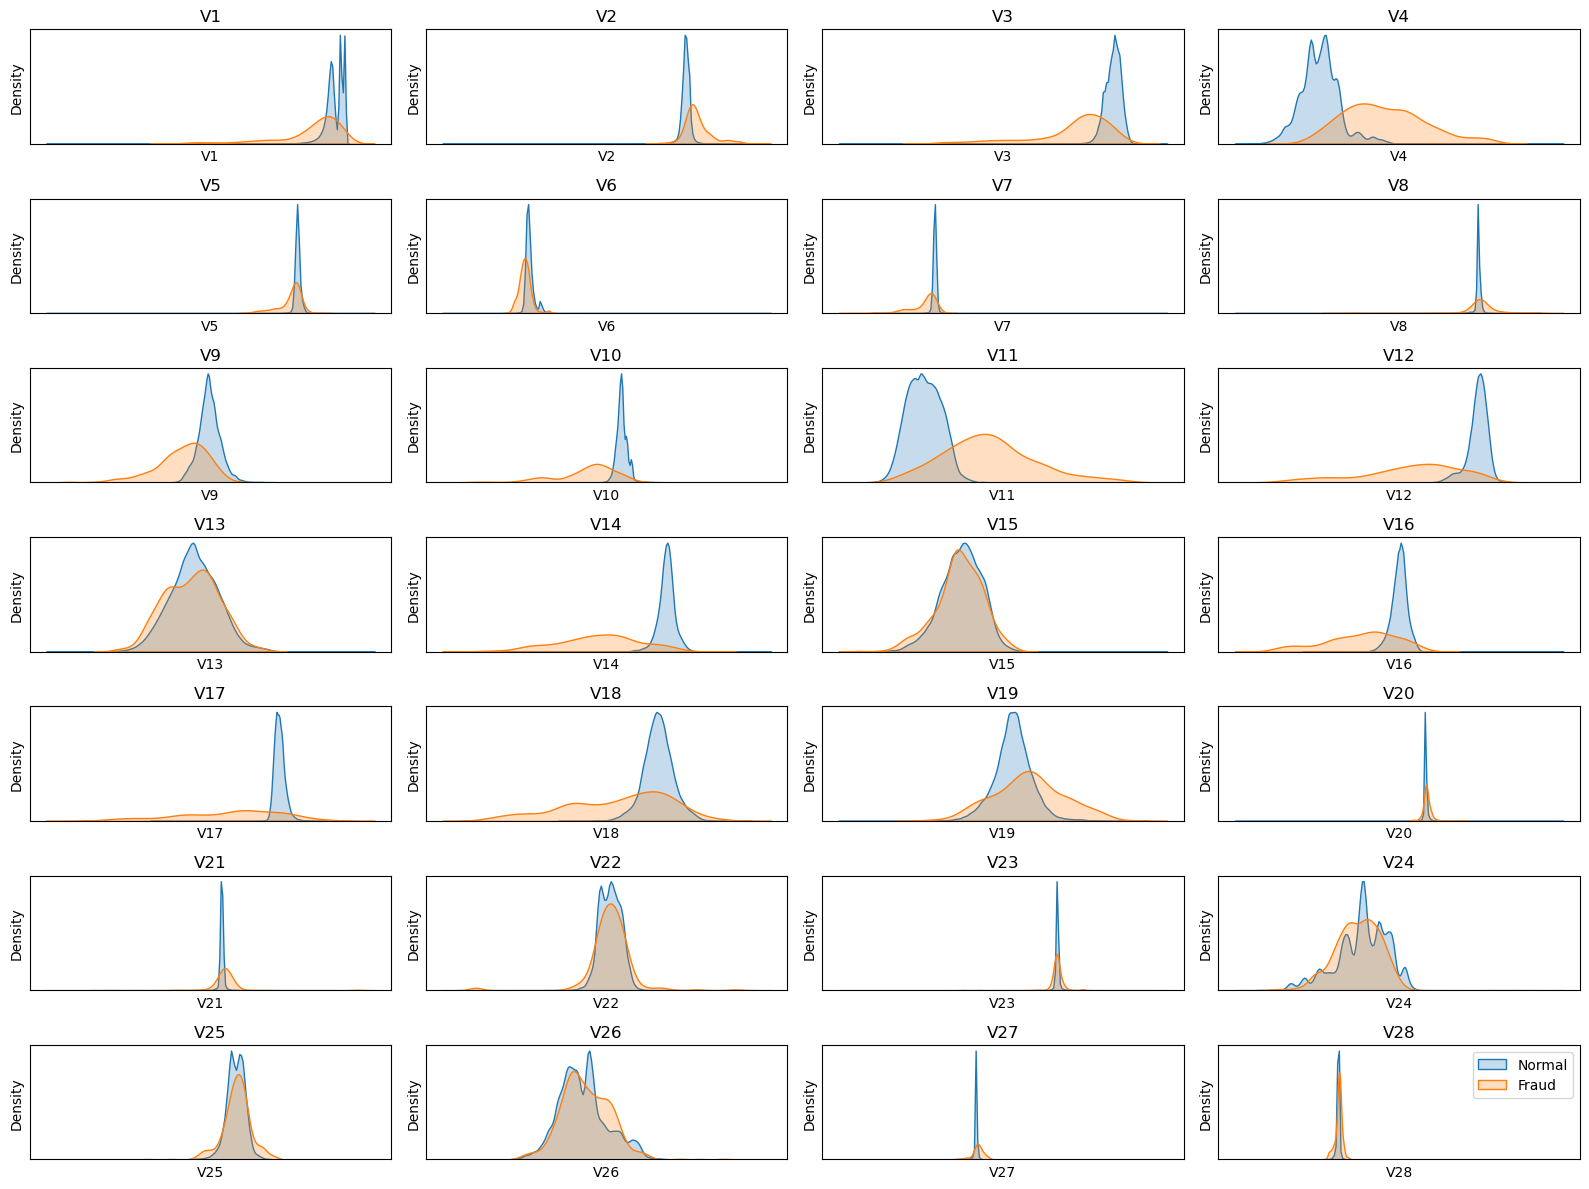

In [14]:
# Check kernel density estimate plots by Class
fraud_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0]

plt.figure(figsize=(16, 12))
for i in range(1, 29):
    plt.subplot(7, 4, i)
    sns.kdeplot(normal_df[f'V{i}'], label='Normal', fill=True)
    sns.kdeplot(fraud_df[f'V{i}'], label='Fraud', fill=True)
    plt.title(f'V{i}')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.legend()

These plots can be used to determine which PCA components are most influential in helping our model learn. Generally speaking, we are looking for plots without a lot of overlap. Depending on model performance, we can drop components that have a lot of overlap to reduce sparsity so the model can learn better.

Text(0.5, 1.0, 'Fraud Count by Hour of Day')

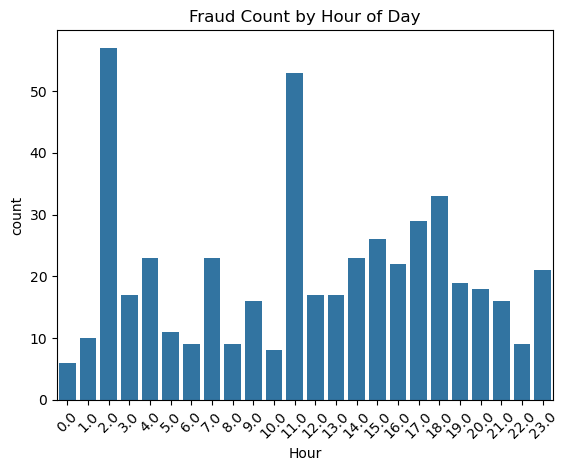

In [17]:
# Fraud per hour
df['Hour'] = (df['Time'] % 86400) // 3600

sns.countplot(data=df[df['Class'] == 1], x='Hour')
plt.xticks(rotation=45)
plt.title("Fraud Count by Hour of Day")

The highest frequencies were at 2 a.m. and 11 a.m. This could allow for the addition of timestamp-based features to be added if the model(s) do not perform well.

In [20]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

There is a huge maximum value of 25691 while the mean is only 88 with std of 250. We will leave the outliers for now, but should adjust the limit for visualization purposes.

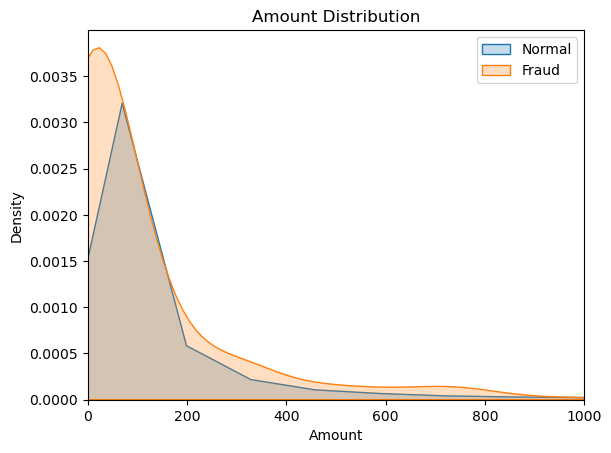

In [22]:
sns.kdeplot(df[df['Class']==0]['Amount'], label='Normal', fill=True)
sns.kdeplot(df[df['Class']==1]['Amount'], label='Fraud', fill=True)
plt.xlim(0, 1000)  # Helps remove noise from huge outliers
plt.title("Amount Distribution")
plt.legend()

The distributions of Amount (presumably in Euros) by Class appear to be relatively similar, but with a notable spike in the lower end of the distribution for fraudulent charges.

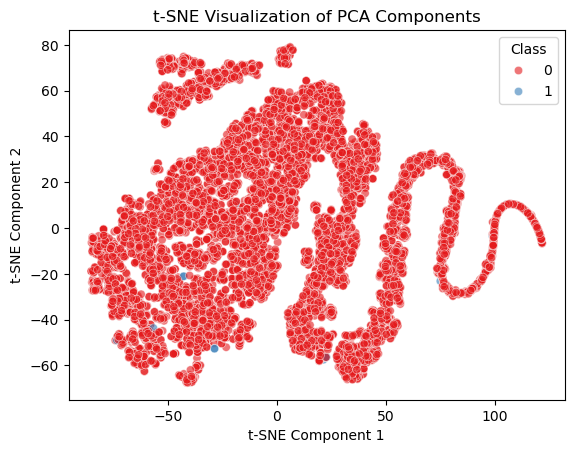

In [24]:
# Sample df
sample_df = df.sample(10000, random_state=42)
X = sample_df.drop(columns=['Class', 'Time']).astype('float64').values

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)

# Plot
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=sample_df['Class'],
    palette='Set1',
    alpha=0.6
)
plt.title("t-SNE Visualization of PCA Components")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Class')
plt.show()

t-distributed Stochastic Neighbor Embedding (t-SNE) is a technique that allows us to visualize high-dimensional data in a 2D or 3D space. Any points or clusters that are close in the plot are close in higher dimensional space. The distances between points far from each other in the plot are not meaningful.

If classes are easily separated in the t-SNE plot, we would know that the features alone (e.g., time, amount, merchant, or location) were enough to separate the legitimate transactions from fraudulent ones. In this case, we can see the blue points are mixed in with the red ones and are, therefore, not easily separated - this means more sophisticated modeling must be done to solve the problem.

## Preprocessing

Next, we preprocess our dataset by defining scoring metrics, our cross-validator, and creating the training and test sets.

In [35]:
# Define scorers
scoring = {
    'precision': 'precision',
    'recall': 'recall',    
    'f1': 'f1',
    'average_precision': 'average_precision'
}

# Define cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X, y preparation
X = df.drop(columns='Class')
y = df['Class']

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Modeling

Now we can begin a preliminary evaluation of several model choices. Then, after selecting the best performing models, we move on to fitting and predicting with those models. And finally, we will perform threshold tuning and finish with Kolmogorov–Smirnov analysis.

#### Model Evaluation

In [32]:
# Function to evaluate model performance
def evaluate_model(model, scale=True):
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps += [('smote', SMOTE(random_state=42, n_jobs=7)), ('classifier', clone(model))]
    
    pipeline = Pipeline(steps)
    results = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, return_train_score=False)
    
    print(f"\nCross-Validation Results for {model.__class__.__name__}")
    for metric in scoring:
        mean = np.mean(results[f'test_{metric}'])
        std = np.std(results[f'test_{metric}'])
        print(f'{metric:<17}: {mean:.4f} ± {std:.4f}')

To compensate for the class imbalance, we used the Synthetic Minority Oversampling Technique (SMOTE). This technique increases the number of minority class samples, which helps models learn patterns in the minority class more effectively. SMOTE can also help reduce bias/overfitting and improve generalizability.

In [50]:
# Create models dictionary
models = {
    'Logistic': LogisticRegression(solver='liblinear', class_weight='balanced', n_jobs=7, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=7, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss',
                             scale_pos_weight=(y==0).sum()/(y==1).sum(), n_jobs=7, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

In [36]:
# Evaluate models
for name, model in models.items():
    scale = name not in ['RandomForest', 'XGBoost']
    evaluate_model(model, scale=scale)


Cross-Validation Results for LogisticRegression
precision        : 0.0562 ± 0.0025
recall           : 0.9138 ± 0.0291
f1               : 0.1059 ± 0.0044
average_precision: 0.7531 ± 0.0479

Cross-Validation Results for RandomForestClassifier
precision        : 0.8984 ± 0.0232
recall           : 0.8199 ± 0.0416
f1               : 0.8564 ± 0.0185
average_precision: 0.8449 ± 0.0277

Cross-Validation Results for XGBClassifier
precision        : 0.6840 ± 0.0489
recall           : 0.8401 ± 0.0324
f1               : 0.7523 ± 0.0235
average_precision: 0.8331 ± 0.0173

Cross-Validation Results for MLPClassifier
precision        : 0.7249 ± 0.0470
recall           : 0.8122 ± 0.0198
f1               : 0.7656 ± 0.0333
average_precision: 0.8170 ± 0.0221


In fraud detection, we can assume the cost of a false negative (flagging as legitimate when the transaction was fraudulent) greatly outweighs that of a false positive (flagging as fraudulent when the transaction was legitimate). Precision measures the model's ability to correctly identify fraudulent transactions while minimizing false positives. Recall, on the other hand, measures the how well the model correctly predicted fraud out of all fraudulent transactions.

Notice with the logistic regression model that recall is very high, but precision is incredibly low - this indicates that while the model correctly identified most fraudulent activity, a very large number of legimate transactions were flagged as fraudulent.

While F1 score can be useful, it balances and weights precision and recall equally - this is problematic if false positives and false negatives have different associated costs, as is the case in fraud detection.

Fortunately, the Precision-Recall Area Under the Curve (PR-AUC) represents the average precision across all possible recall values and is the best single, go-to metric for imbalanced data. Using PR-AUC (average_precision above), we see that Random Forest and XGBoost were the best performing models.

#### Model Fitting & Prediction

In [46]:
# Fit and predict pipeline for best models
def fit_and_predict(model, scale=True):
    X_resampled, y_resampled = SMOTE(random_state=42, n_jobs=7).fit_resample(X_train, y_train)
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps += [('classifier', clone(model))]
    
    pipeline = Pipeline(steps)
    pipeline.fit(X_resampled, y_resampled)
    y_score = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_score >= 0.5).astype(int)
    return y_test, y_pred, y_score

Note: X_resampled and y_resampled were created to apply SMOTE to the training set ONLY. Applying SMOTE to the test set introduces data leakage and may produce overly optimistic results.

In [52]:
# Fit, predict, and save results
results = {}
y_true, y_pred, y_score = fit_and_predict(models['RandomForest'], scale=False)
results['RandomForest'] = {'y_true': y_true, 'y_pred': y_pred, 'y_score': y_score}
y_true, y_pred, y_score = fit_and_predict(models['XGBoost'], scale=False)
results['XGBoost'] = {'y_true': y_true, 'y_pred': y_pred, 'y_score': y_score}

In [66]:
for model, data in results.items():
    print(f'\n--- {model} ---')
    print(classification_report(data['y_true'], data['y_pred']))
    print('Test PR-AUC:', average_precision_score(data['y_true'], data['y_pred']))


--- RandomForest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.83      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Test PR-AUC: 0.6697882404954539

--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.86      0.71        98

    accuracy                           1.00     56962
   macro avg       0.81      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Test PR-AUC: 0.5257932231424869


We used SMOTE in cross-validation pipelines to address imbalance. On the test set, we evaluated performance without SMOTE to simulate real-world fraud detection. The observed drop in performance is expected and typical for fraud settings, where training relies on synthetic balancing but deployment must operate on raw data. Despite the drop in PR-AUC, we can see that recall remained within the same range and even performed slightly better on the test set for both models, with Random Forest winning overall with a much better F1-score.

#### Choosing Number of Trees in Random Forest

While choosing a very large number of trees (n_estimators) in a Random Forest classifier generally improves accuracy by reducing variance without overfitting, there are diminishing returns and an ever-increasing computational cost. It is important, then, to streamline the process by selecting the smallest number of trees that give maximum performance. For consistency, we will use PR-AUC as our metric.

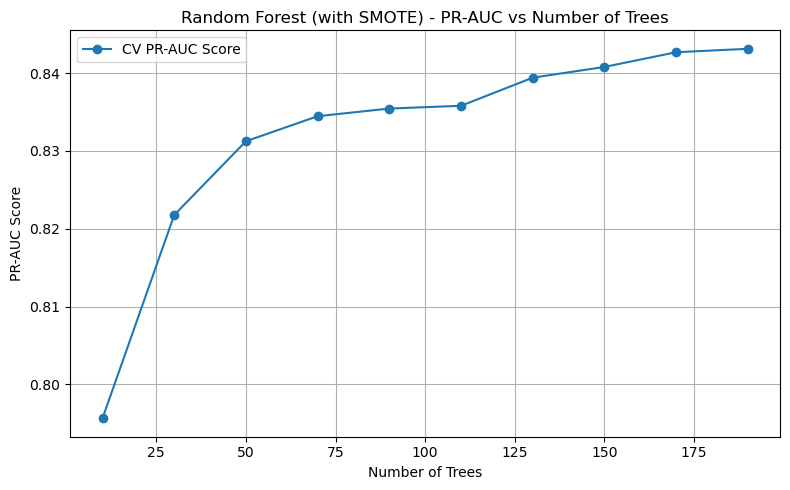

In [41]:
val_scores = []
n_estimators_range = range(10, 210, 20)

for n in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n,
        class_weight='balanced',
        n_jobs=7,
        random_state=42
    )
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, n_jobs=7)),
        ('clf', rf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='average_precision')
    val_scores.append(scores.mean())

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, val_scores, label='CV PR-AUC Score', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('PR-AUC Score')
plt.title('Random Forest (with SMOTE) - PR-AUC vs Number of Trees')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In the plot, we see that gains in PR-AUC jump rapidly from 10 to 50 trees. The curve continues to climb to about 75 trees and begins to plateau. From 100 trees onward, the gains are minimal. While 50-75 trees would be optimal for minimzing training time in a production environment, it is still fine to use 100 trees here for a better balance between speed and performance.

#### Threshold Tuning

In [110]:
# Threshold tuning
def threshold_tuning(model, scale=True):
    print(f"Threshold Tuning for {model.__class__.__name__}")
    thresholds = np.arange(0.1, 0.91, 0.05)
    f1_scores, recalls, precisions = [], [], []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        steps = []
        if scale:
            steps.append(('scaler', StandardScaler()))
        steps += [('smote', SMOTE(random_state=42, n_jobs=7)), ('classifier', clone(model))]

        pipeline = Pipeline(steps)
        pipeline.fit(X_tr, y_tr)
        probas = pipeline.predict_proba(X_val)[:, 1]

        for t in thresholds:
            preds = (probas >= t).astype(int)
            f1_scores.append(f1_score(y_val, preds))
            recalls.append(recall_score(y_val, preds))
            precisions.append(precision_score(y_val, preds))

    # Aggregate and plot
    mean_f1 = [np.mean(f1_scores[i::len(thresholds)]) for i in range(len(thresholds))]
    mean_rec = [np.mean(recalls[i::len(thresholds)]) for i in range(len(thresholds))]
    mean_prec = [np.mean(precisions[i::len(thresholds)]) for i in range(len(thresholds))]

    print(f"{'Threshold':<10} {'F1':<8} {'Recall':<8} {'Precision':<8}")
    for t, f, r, p in zip(thresholds, mean_f1, mean_rec, mean_prec):
        print(f"{t:<10.2f} {f:<8.4f} {r:<8.4f} {p:<8.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, mean_f1, label='F1 Score')
    plt.plot(thresholds, mean_rec, label='Recall')
    plt.plot(thresholds, mean_prec, label='Precision')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{model.__class__.__name__} - Threshold Tuning")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Threshold Tuning for RandomForestClassifier
Threshold  F1       Recall   Precision
0.10       0.4586   0.8757   0.3113  
0.15       0.6319   0.8605   0.5020  
0.20       0.7315   0.8452   0.6471  
0.25       0.7832   0.8427   0.7347  
0.30       0.8169   0.8351   0.8045  
0.35       0.8330   0.8300   0.8392  
0.40       0.8394   0.8250   0.8568  
0.45       0.8526   0.8250   0.8845  
0.50       0.8564   0.8199   0.8984  
0.55       0.8524   0.8097   0.9024  
0.60       0.8477   0.7995   0.9038  
0.65       0.8484   0.7970   0.9083  
0.70       0.8465   0.7919   0.9102  
0.75       0.8395   0.7716   0.9221  
0.80       0.8357   0.7564   0.9345  
0.85       0.8220   0.7285   0.9450  
0.90       0.8057   0.6929   0.9664  


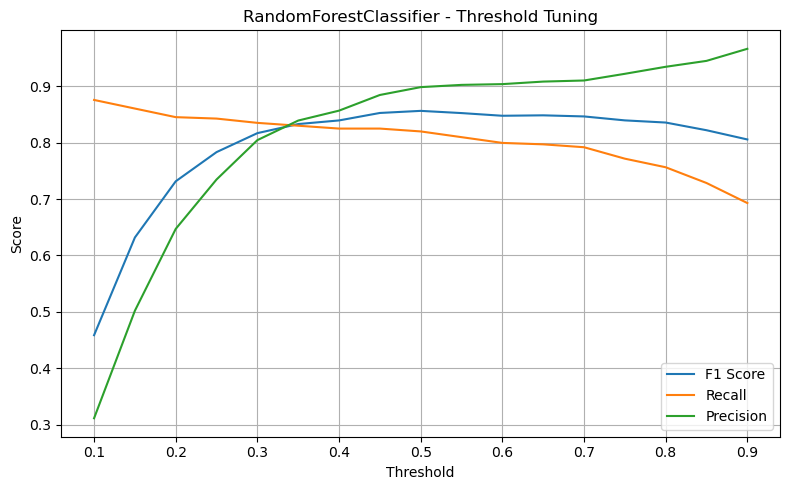

In [126]:
# Threshold tuning
threshold_tuning(models['RandomForest'], scale=False)

Threshold tuning may be valuable depending on business needs. The default threshold of 0.5 gives a higher precision than recall for Random Forest with this dataset - this is most likely not ideal for fraud detection. Since we want to maximize detection without having too many false alarms, it might be best to use a threshold of 0.25 or 0.30.

Threshold Tuning for XGBClassifier
Threshold  F1       Recall   Precision
0.10       0.6044   0.8452   0.4726  
0.15       0.6409   0.8452   0.5187  
0.20       0.6715   0.8427   0.5609  
0.25       0.6977   0.8427   0.5984  
0.30       0.7165   0.8427   0.6257  
0.35       0.7244   0.8427   0.6377  
0.40       0.7348   0.8427   0.6537  
0.45       0.7442   0.8427   0.6685  
0.50       0.7523   0.8401   0.6840  
0.55       0.7618   0.8401   0.7000  
0.60       0.7673   0.8401   0.7096  
0.65       0.7694   0.8376   0.7157  
0.70       0.7774   0.8376   0.7290  
0.75       0.7904   0.8376   0.7524  
0.80       0.7973   0.8351   0.7666  
0.85       0.8093   0.8326   0.7917  
0.90       0.8166   0.8275   0.8110  


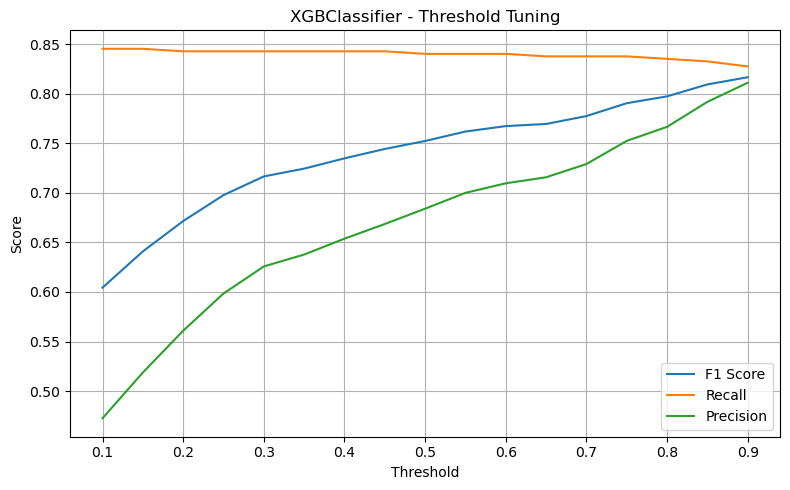

In [128]:
threshold_tuning(models['XGBoost'], scale=False)

Recall is very high across the entire range for XGBoost and only begins drop off ever so slightly near the end, so the highest threshold of 0.9 might be best to minimize false positives without sacrificing much detection.

#### Kolmogorov–Smirnov Analysis

The Kolmogorov-Smirnov (KS) test is typically used to determine if an unknown distribution matches a known distribution (e.g., normal distribution), also known as a goodness-of-fit test, or if two samples are likely drawn from the same distribution by measuring the maximum distance between their cumulative distribution functions. We will do the latter.

For the case of fraud detection, one distribution represents legitimate transactions and the other fraudulent ones. The KS statistic computed is a value between 0 and 1, where values closer to 1 indicate a greater difference in distributions and, consequently, the model's ability to distinguish between classes.

In [17]:
# KS function
def compute_ks_and_threshold(y_true, y_score, target_capture_rate=0.9):
    df = pd.DataFrame({'y_true': y_true, 'y_score': y_score}).sort_values('y_score', ascending=False).reset_index(drop=True)
    df['cum_total'] = np.arange(1, len(df)+1)
    df['cum_fraud'] = df['y_true'].cumsum()
    df['cum_nonfraud'] = df['cum_total'] - df['cum_fraud']
    total_fraud = df['y_true'].sum()
    total_nonfraud = len(df) - total_fraud
    df['cum_fraud_rate'] = df['cum_fraud'] / total_fraud
    df['cum_nonfraud_rate'] = df['cum_nonfraud'] / total_nonfraud
    df['ks_stat'] = df['cum_fraud_rate'] - df['cum_nonfraud_rate']

    ks_stat = df['ks_stat'].max()
    ks_idx = df['ks_stat'].idxmax()
    ks_threshold = df.loc[ks_idx, 'y_score']
    capture_idx = df[df['cum_fraud_rate'] >= target_capture_rate].index[0]
    capture_percent_of_data = (capture_idx + 1) / len(df)
    capture_threshold = df.loc[capture_idx, 'y_score']

    print(f'KS Statistic: {ks_stat:.4f} at threshold {ks_threshold:.4f}')
    print(f'To capture {target_capture_rate*100:.0f}% of frauds, analyze top {capture_percent_of_data*100:.1f}% of data (threshold: {capture_threshold:.4f})')

    return {
        'ks_stat': ks_stat,
        'ks_threshold': ks_threshold,
        'capture_threshold': capture_threshold,
        'capture_percent_of_data': capture_percent_of_data
    }

In [102]:
# KS analysis for Random Forest
compute_ks_and_threshold(results['RandomForest']['y_true'], results['RandomForest']['y_score'])

KS Statistic: 0.9073 at threshold 0.0500
To capture 90% of frauds, analyze top 0.4% of data (threshold: 0.1200)


{'ks_stat': 0.9072706952786742,
 'ks_threshold': 0.05,
 'capture_threshold': 0.12,
 'capture_percent_of_data': 0.004230890769284786}

In [104]:
# KS analysis for XGBoost
compute_ks_and_threshold(results['XGBoost']['y_true'], results['XGBoost']['y_score'])

KS Statistic: 0.9025 at threshold 0.0129
To capture 90% of frauds, analyze top 0.7% of data (threshold: 0.0129)


{'ks_stat': 0.9025006316538996,
 'ks_threshold': 0.012858438,
 'capture_threshold': 0.012858438,
 'capture_percent_of_data': 0.007215336540149574}

In [90]:
y_test.value_counts()

Class
0    56864
1       98
Name: count, dtype: int64

**Why care about KS analysis?**  
If resources for manual checking are limited and must be prioritized, the threshold for y_pred can be set to 0.0500 for the Random Forest model or 0.0129 for XGBoost to capture 90% of fraudulent transactions within a small sample of the whole dataset. In the case of the Random Forest model, this means a company would only need to manually check the top 0.4% of the data, i.e., 228 of the total 56,962 transactions, to catch 90% of all fraudulent transactions.